upload kaggle.json

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zwang217","key":"60e47be33299cd2bef698e63bb64b790"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip -q /content/face-expression-recognition-dataset.zip
!mv /content/images/ ~

kaggle.json
 95% 115M/121M [00:01<00:00, 69.3MB/s]
100% 121M/121M [00:01<00:00, 71.7MB/s]


Get data

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms
import os


class facialDataset(Dataset):
  def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
  
  def __len__(self):
    return len(self.arr)

  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    image = image.type(torch.float)
    label = self.label_dict.get(self.arr[idx][0])
    return image, torch.tensor(label)

class facialDatasetAug(Dataset):
  def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6}
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
  
  def __len__(self):
    return len(self.arr)

  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    cropper = torchvision.transforms.RandomCrop(46, padding=1, padding_mode='edge');
    image = cropper(image)
    flipper = torchvision.transforms.RandomHorizontalFlip(p=0.5)
    image = flipper(image)
    image = image.type(torch.float)
    label = self.label_dict.get(self.arr[idx][0])
    return image, torch.tensor(label)



In [ ]:
from torch.utils.data import DataLoader

trainDataset = facialDataset("/root/images/train")
testDataset = facialDataset("/root/images/validation")

train_dataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testDataset, batch_size=128, shuffle=False)

In [ ]:
print(trainDataset[0][0])
print(trainDataset[0][1])

tensor([[[255., 252., 248.,  ..., 253., 255., 254.],
         [254., 249., 243.,  ..., 248., 254., 254.],
         [251., 245., 236.,  ..., 241., 250., 255.],
         ...,
         [250., 253., 255.,  ..., 253., 251., 239.],
         [247., 252., 255.,  ..., 254., 247., 236.],
         [243., 250., 255.,  ..., 253., 244., 233.]]])
tensor(5)


Check if device is GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Add simple network with three layers and conv network.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, inputs=2304, hidden1=1024, hidden2 = 512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.tanh(x) 
        x = self.fc2(x)
        x = torch.tanh(x) 
        x = self.fc3(x)
        return x


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(2304, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x) 
        return x


Trainning code

In [ ]:
import numpy
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss() # Combination softmax + negative log likelihood
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return numpy.convolve(x, numpy.ones(size)/size, mode='valid')

Train the simple network with three layers.

In [ ]:
import matplotlib.pyplot as plt

net = SimpleNet()

losses = train(net, train_dataloader, epochs=15)
plt.plot(smooth(losses,50))

print("Training accuracy: %f" % accuracy(net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(net, test_dataloader))
# # lr                training_accuracy   testing_accuracy
# # 0.00001           0.251622            0.254316
# # 0.0001            0.284896            0.277102
# # 0.001(best)       0.303147            0.303425
# # 0.01(default)     0.249540            0.258704
# # 0.1               0.172860            0.172092
# # 
# # with lr=0.001 (no effect)
# # decay             training_accuracy   testing_accuracy
# # 0.0(default)      0.280906            0.289414
# # 1                 0.248569            0.258279
# # 0.1               0.279900            0.283895
# # 0.01              0.302731            0.305265
# # 0.001             0.289546            0.290829
# # 0.0001            0.305194            0.308378
# # 0.00001           0.290552            0.294933
# # 
# # with lr=0.001 and decay=0.0001 (no effect)
# # momentum          training_accuracy   testing_accuracy
# # 0.0(default)      0.317720            0.312058
# # 1                 0.173034            0.172375
# # 0.1               0.291454            0.297905
# # 0.01              0.288123            0.286584
# # 0.001             0.307866            0.312765
# # 0.0001            0.297214            0.300028

[1,   100] loss: 1.869
[1,   200] loss: 1.840


KeyboardInterrupt: ignored

Train the cov network

[1,   100] loss: 1.973
[1,   200] loss: 1.790
[2,   100] loss: 1.727
[2,   200] loss: 1.705
[3,   100] loss: 1.673
[3,   200] loss: 1.661
[4,   100] loss: 1.640
[4,   200] loss: 1.639
[5,   100] loss: 1.616
[5,   200] loss: 1.614
[6,   100] loss: 1.595
[6,   200] loss: 1.594
[7,   100] loss: 1.583
[7,   200] loss: 1.573
[8,   100] loss: 1.570
[8,   200] loss: 1.554
[9,   100] loss: 1.552
[9,   200] loss: 1.551
[10,   100] loss: 1.537
[10,   200] loss: 1.537
[11,   100] loss: 1.511
[11,   200] loss: 1.526
[12,   100] loss: 1.516
[12,   200] loss: 1.512
[13,   100] loss: 1.495
[13,   200] loss: 1.505
[14,   100] loss: 1.487
[14,   200] loss: 1.487
[15,   100] loss: 1.479
[15,   200] loss: 1.469
Training accuracy: 0.439645
Testing  accuracy: 0.403765


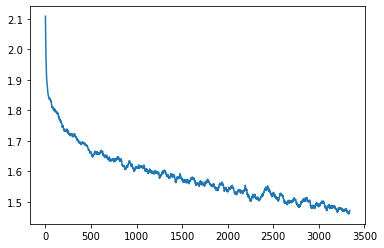

In [ ]:
import matplotlib.pyplot as plt

net = ConvNet()

losses = train(net, train_dataloader, epochs=15, lr=0.0001)
plt.plot(smooth(losses,50))

print("Training accuracy: %f" % accuracy(net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(net, test_dataloader))
# lr                training_accuracy   testing_accuracy
# 0.00001           0.354151            0.344750
# 0.0001(best)      0.437736            0.411265
# 0.001             0.417196            0.395839
# 0.01(default)     0.248569            0.258279
# 0.1               0.248569            0.258279
# 
# with lr=0.0001 (no effect)
# decay             training_accuracy   testing_accuracy
# 0                 0.449290            0.420606
# 0.001             0.445613            0.421738
# 0.01              0.453211            0.416926
# 0.1               0.431803            0.416360



Simulated Annealing (slowly lower the learning rate over time)

[1,   100] loss: 2.248
[1,   200] loss: 1.787
[2,   100] loss: 1.740
[2,   200] loss: 1.715
[3,   100] loss: 1.693
[3,   200] loss: 1.687
[4,   100] loss: 1.658
[4,   200] loss: 1.653
[5,   100] loss: 1.634
[5,   200] loss: 1.628
[1,   100] loss: 1.613
[1,   200] loss: 1.599
[2,   100] loss: 1.602
[2,   200] loss: 1.595
[3,   100] loss: 1.593
[3,   200] loss: 1.601
[4,   100] loss: 1.596
[4,   200] loss: 1.596
[5,   100] loss: 1.599
[5,   200] loss: 1.589
[1,   100] loss: 1.595
[1,   200] loss: 1.593
[2,   100] loss: 1.586
[2,   200] loss: 1.598
[3,   100] loss: 1.586
[3,   200] loss: 1.596
[4,   100] loss: 1.586
[4,   200] loss: 1.599
[5,   100] loss: 1.594
[5,   200] loss: 1.591
Training accuracy: 0.393047
Testing  accuracy: 0.386782


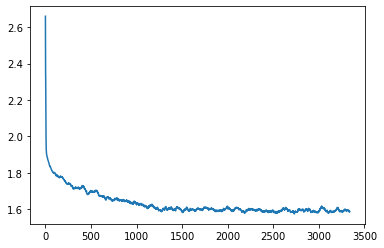

In [ ]:
import matplotlib.pyplot as plt

# (no effect)
anneal_net = ConvNet()

anneal_losses =  train(anneal_net, train_dataloader, epochs=5, lr=.0001)
anneal_losses += train(anneal_net, train_dataloader, epochs=5, lr=.00001)
anneal_losses += train(anneal_net, train_dataloader, epochs=5, lr=.000001)

plt.plot(smooth(anneal_losses, 50))

print("Training accuracy: %f" % accuracy(anneal_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(anneal_net, test_dataloader))

A new convolutional network with batch normalization

In [ ]:
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        #self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        #self.bn1 = nn.BatchNorm2d(16)
        #self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        #self.bn2 = nn.BatchNorm2d(32)
        #elf.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        #self.bn3 = nn.BatchNorm2d(64)
        #self.fc1 = nn.Linear(2304, 10)
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(2304, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x



Train the ConvBNNet

[1,   100] loss: 1.731
[1,   200] loss: 1.599
[2,   100] loss: 1.423
[2,   200] loss: 1.419
[3,   100] loss: 1.275
[3,   200] loss: 1.295
[4,   100] loss: 1.167
[4,   200] loss: 1.184
[5,   100] loss: 1.060
[5,   200] loss: 1.100
[6,   100] loss: 0.964
[6,   200] loss: 1.007
[7,   100] loss: 0.884
[7,   200] loss: 0.944
[8,   100] loss: 0.804
[8,   200] loss: 0.861
[9,   100] loss: 0.725
[9,   200] loss: 0.784
[10,   100] loss: 0.643
[10,   200] loss: 0.725
[11,   100] loss: 0.588
[11,   200] loss: 0.649
[12,   100] loss: 0.503
[12,   200] loss: 0.574
[13,   100] loss: 0.459
[13,   200] loss: 0.524
[14,   100] loss: 0.394
[14,   200] loss: 0.462
[15,   100] loss: 0.351
[15,   200] loss: 0.418
Training accuracy: 0.908539
Testing  accuracy: 0.467167


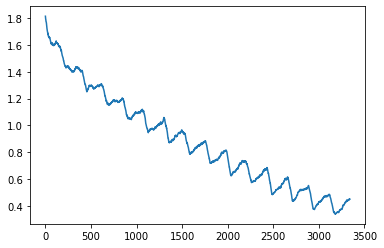

In [ ]:
norm_net = ConvBNNet()

norm_losses = train(norm_net, train_dataloader, epochs=15, lr=.01)

plt.plot(smooth(norm_losses, 50))

print("Training accuracy: %f" % accuracy(norm_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(norm_net, test_dataloader))
# lr                training_accuracy   testing_accuracy 
# 0.001             0.614760            0.436598
# 0.01(default)     0.796954            0.452165
# 0.1               0.492245            0.425984

Train the ConvBNNet with simulated annealing

[1,   100] loss: 1.734
[1,   200] loss: 1.599
[2,   100] loss: 1.458
[2,   200] loss: 1.411
[3,   100] loss: 1.302
[3,   200] loss: 1.300
[4,   100] loss: 1.190
[4,   200] loss: 1.195
[5,   100] loss: 1.079
[5,   200] loss: 1.118
[1,   100] loss: 0.912
[1,   200] loss: 0.882
[2,   100] loss: 0.837
[2,   200] loss: 0.854
[3,   100] loss: 0.811
[3,   200] loss: 0.821
[4,   100] loss: 0.790
[4,   200] loss: 0.796
[5,   100] loss: 0.758
[5,   200] loss: 0.781
[1,   100] loss: 0.741
[1,   200] loss: 0.729
[2,   100] loss: 0.733
[2,   200] loss: 0.727
[3,   100] loss: 0.729
[3,   200] loss: 0.730
[4,   100] loss: 0.724
[4,   200] loss: 0.725
[5,   100] loss: 0.724
[5,   200] loss: 0.719
Training accuracy: 0.768953
Testing  accuracy: 0.504246


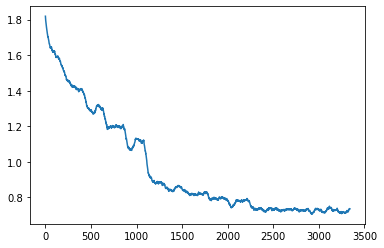

In [ ]:
anneal2_net = ConvBNNet()

anneal2_losses =  train(anneal2_net, train_dataloader, epochs=5, lr=.01)
anneal2_losses += train(anneal2_net, train_dataloader, epochs=5, lr=.001)
anneal2_losses += train(anneal2_net, train_dataloader, epochs=5, lr=.0001)


plt.plot(smooth(anneal2_losses, 50))

print("Training accuracy: %f" % accuracy(anneal2_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(anneal2_net, test_dataloader))

Try with weight decay

[1,   100] loss: 1.726
[1,   200] loss: 1.557
[2,   100] loss: 1.446
[2,   200] loss: 1.389
[3,   100] loss: 1.304
[3,   200] loss: 1.311
[4,   100] loss: 1.234
[4,   200] loss: 1.260
[5,   100] loss: 1.179
[5,   200] loss: 1.212
[1,   100] loss: 1.078
[1,   200] loss: 1.051
[2,   100] loss: 1.004
[2,   200] loss: 1.017
[3,   100] loss: 0.986
[3,   200] loss: 0.983
[4,   100] loss: 0.952
[4,   200] loss: 0.958
[5,   100] loss: 0.926
[5,   200] loss: 0.951
[1,   100] loss: 0.896
[1,   200] loss: 0.896
[2,   100] loss: 0.886
[2,   200] loss: 0.890
[3,   100] loss: 0.881
[3,   200] loss: 0.890
[4,   100] loss: 0.882
[4,   200] loss: 0.880
[5,   100] loss: 0.879
[5,   200] loss: 0.881
Training accuracy: 0.709968
Testing  accuracy: 0.508491


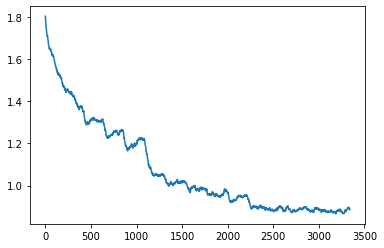

In [ ]:
decay_net = ConvBNNet()

decay_losses =  train(decay_net, train_dataloader, epochs=5, lr=.01  , decay = .01)
decay_losses += train(decay_net, train_dataloader, epochs=5, lr=.001 , decay = .01)
decay_losses += train(decay_net, train_dataloader, epochs=5, lr=.0001, decay = .01)


plt.plot(smooth(decay_losses, 50))

print("Training accuracy: %f" % accuracy(decay_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(decay_net, test_dataloader))

Try data augmentation

In [ ]:
from torch.utils.data import DataLoader

trainDatasetAug = facialDatasetAug("/root/images/train")
testDatasetAug = facialDatasetAug("/root/images/validation")

train_dataloader_aug = DataLoader(trainDatasetAug, batch_size=128, shuffle=True, num_workers=2)
test_dataloader_aug = DataLoader(testDatasetAug, batch_size=128, shuffle=False, num_workers=2)

data_net = ConvBNNet()

data_losses =  train(data_net, train_dataloader_aug, epochs=5, lr=.01  , decay = .01)
data_losses += train(data_net, train_dataloader_aug, epochs=5, lr=.001 , decay = .01)
data_losses += train(data_net, train_dataloader_aug, epochs=5, lr=.0001, decay = .01)



[1,   100] loss: 1.771
[1,   200] loss: 1.625
[2,   100] loss: 1.546
[2,   200] loss: 1.491
[3,   100] loss: 1.442
[3,   200] loss: 1.431
[4,   100] loss: 1.376
[4,   200] loss: 1.366
[5,   100] loss: 1.340
[5,   200] loss: 1.336
[1,   100] loss: 1.276
[1,   200] loss: 1.258
[2,   100] loss: 1.241
[2,   200] loss: 1.232
[3,   100] loss: 1.226
[3,   200] loss: 1.223
[4,   100] loss: 1.210
[4,   200] loss: 1.224
[5,   100] loss: 1.214
[5,   200] loss: 1.198
[1,   100] loss: 1.193
[1,   200] loss: 1.181
[2,   100] loss: 1.184
[2,   200] loss: 1.189
[3,   100] loss: 1.194
[3,   200] loss: 1.180
[4,   100] loss: 1.190
[4,   200] loss: 1.186
[5,   100] loss: 1.176
[5,   200] loss: 1.182


Training accuracy: 0.563790
Testing  accuracy: 0.492499


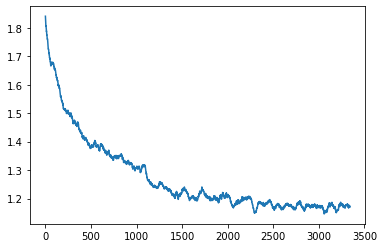

In [ ]:
import matplotlib.pyplot as plt
plt.plot(smooth(data_losses, 50))

print("Training accuracy: %f" % accuracy(data_net, train_dataloader_aug))
print("Testing  accuracy: %f" % accuracy(data_net, test_dataloader_aug))

Combine category of angry, disgust, fear, surprise

[1,   100] loss: 1.257
[1,   200] loss: 1.163
[2,   100] loss: 1.063
[2,   200] loss: 1.031
[3,   100] loss: 0.973
[3,   200] loss: 0.964
[4,   100] loss: 0.933
[4,   200] loss: 0.936
[5,   100] loss: 0.903
[5,   200] loss: 0.932
[1,   100] loss: 0.849
[1,   200] loss: 0.827
[2,   100] loss: 0.822
[2,   200] loss: 0.810
[3,   100] loss: 0.797
[3,   200] loss: 0.811
[4,   100] loss: 0.788
[4,   200] loss: 0.795
[5,   100] loss: 0.778
[5,   200] loss: 0.780
[1,   100] loss: 0.772
[1,   200] loss: 0.749
[2,   100] loss: 0.763
[2,   200] loss: 0.754
[3,   100] loss: 0.754
[3,   200] loss: 0.759
[4,   100] loss: 0.755
[4,   200] loss: 0.759
[5,   100] loss: 0.753
[5,   200] loss: 0.756
Training accuracy: 0.716318
Testing  accuracy: 0.582366


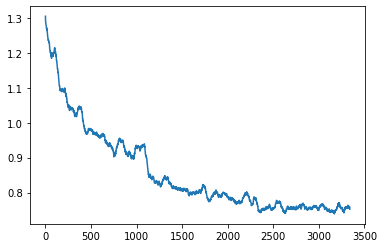

In [ ]:
class facialNewDataset(Dataset):
  def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 0, "fear": 0, "happy": 1, "neutral": 2, "sad": 3, "surprise": 0}
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
        #self.dic.add(int(index), dir)
  
  def __len__(self):
    return len(self.arr)

  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    image = image.type(torch.float)
    label = self.label_dict[self.arr[idx][0]]
    return image, torch.tensor(label)

trainDataset = facialNewDataset("/root/images/train")
testDataset = facialNewDataset("/root/images/validation")
train_dataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testDataset, batch_size=128, shuffle=False)

class ConvBNNet2(nn.Module):
    def __init__(self):
        super(ConvBNNet2, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        #self.fc1 = nn.Linear(2304, 10)
        self.fc1 = nn.Linear(2304, 5)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

new_decay_net = ConvBNNet2()
decay_losses =  train(new_decay_net, train_dataloader, epochs=5, lr=.01  , decay = .01)
decay_losses += train(new_decay_net, train_dataloader, epochs=5, lr=.001 , decay = .01)
decay_losses += train(new_decay_net, train_dataloader, epochs=5, lr=.0001, decay = .01)


plt.plot(smooth(decay_losses, 50))

print("Training accuracy: %f" % accuracy(new_decay_net, train_dataloader))
print("Testing  accuracy: %f" % accuracy(new_decay_net, test_dataloader))

Combine category of disgust, fear, surprise

[1,   100] loss: 1.524
[1,   200] loss: 1.417
[2,   100] loss: 1.331
[2,   200] loss: 1.300
[3,   100] loss: 1.258
[3,   200] loss: 1.261
[4,   100] loss: 1.226
[4,   200] loss: 1.217
[5,   100] loss: 1.216
[5,   200] loss: 1.209
[6,   100] loss: 1.192
[6,   200] loss: 1.188
[7,   100] loss: 1.187
[7,   200] loss: 1.187
[8,   100] loss: 1.166
[8,   200] loss: 1.181
[9,   100] loss: 1.174
[9,   200] loss: 1.168
[10,   100] loss: 1.177
[10,   200] loss: 1.167
[11,   100] loss: 1.155
[11,   200] loss: 1.162
[12,   100] loss: 1.174
[12,   200] loss: 1.151
[13,   100] loss: 1.144
[13,   200] loss: 1.163
[14,   100] loss: 1.154
[14,   200] loss: 1.158
[15,   100] loss: 1.149
[15,   200] loss: 1.147
[16,   100] loss: 1.146
[16,   200] loss: 1.144
[17,   100] loss: 1.148
[17,   200] loss: 1.142
[18,   100] loss: 1.152
[18,   200] loss: 1.136
[19,   100] loss: 1.141
[19,   200] loss: 1.138
[20,   100] loss: 1.146
[20,   200] loss: 1.152
[21,   100] loss: 1.134
[21,   200] loss: 1.140
[22,   100

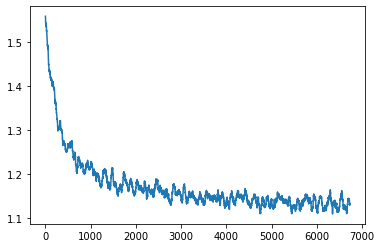

In [ ]:
class NewfacialDatasetAug(Dataset):
  #def __init__(self, directory, transform):
  def __init__(self, directory):
    self.arr = []
    self.directory = directory
    self.label_dict = {"angry": 0, "disgust": 1, "fear": 1, "happy": 2, "neutral": 3, "sad": 4, "surprise": 1}
    # self.transform = transform
    for dir in os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dir)):
        index = filename[:-len(".jpg")]
        self.arr.append((dir, index))
        #self.dic.add(int(index), dir)
  
  def __len__(self):
    return len(self.arr)

  def __getitem__(self, idx):
    img_path = os.path.join(self.directory, self.arr[idx][0], self.arr[idx][1] + ".jpg")
    image = read_image(img_path)
    cropper = torchvision.transforms.RandomCrop(46, padding=1, padding_mode='edge');
    image = cropper(image)
    flipper = torchvision.transforms.RandomHorizontalFlip(p=0.5)
    image = flipper(image)
    image = image.type(torch.float)
    label = self.label_dict.get(self.arr[idx][0])
    return image, torch.tensor(label)

trainDatasetAug = NewfacialDatasetAug("/root/images/train")
testDatasetAug = NewfacialDatasetAug("/root/images/validation")

train_dataloader_aug = DataLoader(trainDatasetAug, batch_size=128, shuffle=True, num_workers=2)
test_dataloader_aug = DataLoader(testDatasetAug, batch_size=128, shuffle=False, num_workers=2)

new_decay_net = ConvBNNet2()
decay_losses =  train(new_decay_net, train_dataloader_aug, epochs=30, lr=.01  , decay = .01)
# decay_losses += train(new_decay_net, train_dataloader_aug, epochs=30, lr=.001 , decay = .01)
# decay_losses += train(new_decay_net, train_dataloader_aug, epochs=50, lr=.0001, decay = .01)


plt.plot(smooth(decay_losses, 50))

print("Training accuracy: %f" % accuracy(new_decay_net, train_dataloader_aug))
print("Testing  accuracy: %f" % accuracy(new_decay_net, test_dataloader_aug))